<a href="https://colab.research.google.com/github/Bolorooo24/CV-ML_labs/blob/main/Lab_2/Task_1/Resnet50_CIFAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import cv2
import numpy as np
from matplotlib import pyplot as plt
from torchvision import datasets
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
batch_size = 128

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor()])

In [4]:
trainset = torchvision.datasets.CIFAR10(root='./cifar', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=4)

testset = torchvision.datasets.CIFAR10(root='./cifar', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=4)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170M/170M [00:13<00:00, 12.8MB/s]


Extracting ./cifar/cifar-10-python.tar.gz to ./cifar


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Files already downloaded and verified


In [6]:
class ResNet50CustomInput(nn.Module):
    def __init__(self, num_classes, input_channels):
        super(ResNet50CustomInput, self).__init__()

        # Load the pre-trained ResNet-50 model without the final classification layer
        self.resnet = models.resnet50(pretrained=True)
        # Remove the original fully connected layer
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-2])

        # Modify the first convolution layer to accept smaller input
        self.resnet[0] = nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1, bias=False)

        # Adaptive average pooling layer to adapt to different input sizes
        self.avgpool = nn.AdaptiveAvgPool2d(1)

        # New fully connected layer for your specific number of classes
        self.fc = nn.Linear(2048, num_classes)

    def forward(self, x):
        x = self.resnet(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Instantiate the modified ResNet-50 model
num_classes = 10  # Adjust to your specific number of classes
input_channels = 3  # Adjust to match your input data channels
model = ResNet50CustomInput(num_classes, input_channels)
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 98.3MB/s]


In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [8]:
def train(model, train_loader, optimizer, criterion, epoch):
    model.train()
    for batch_idx, data in enumerate(train_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(inputs), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [9]:
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            output = model(inputs)
            test_loss += criterion(output, labels).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(labels.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), accuracy))

In [10]:
epochs = 10
for epoch in range(1, epochs + 1):
    train(model, train_loader, optimizer, criterion, epoch)
    test(model, test_loader)
    torch.save(model.state_dict(), 'cifar_resnet50_model.pth')
    print('model saved')

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.473721
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.038339
Train Epoch: 1 [25600/50000 (51%)]	Loss: 0.794336
Train Epoch: 1 [38400/50000 (77%)]	Loss: 0.924060

Test set: Average loss: 0.0070, Accuracy: 6905/10000 (69.05%)

model saved
Train Epoch: 2 [0/50000 (0%)]	Loss: 0.651869
Train Epoch: 2 [12800/50000 (26%)]	Loss: 0.468148
Train Epoch: 2 [25600/50000 (51%)]	Loss: 0.443098
Train Epoch: 2 [38400/50000 (77%)]	Loss: 0.500616

Test set: Average loss: 0.0055, Accuracy: 7595/10000 (75.95%)

model saved
Train Epoch: 3 [0/50000 (0%)]	Loss: 0.341400
Train Epoch: 3 [12800/50000 (26%)]	Loss: 0.243552
Train Epoch: 3 [25600/50000 (51%)]	Loss: 0.414713
Train Epoch: 3 [38400/50000 (77%)]	Loss: 0.363834

Test set: Average loss: 0.0048, Accuracy: 7992/10000 (79.92%)

model saved
Train Epoch: 4 [0/50000 (0%)]	Loss: 0.296920
Train Epoch: 4 [12800/50000 (26%)]	Loss: 0.230908
Train Epoch: 4 [25600/50000 (51%)]	Loss: 0.163810
Train Epoch: 4 [38400/50000 (77%)]	Loss: 0

In [12]:
loaded_net = ResNet50CustomInput(num_classes, input_channels)
checkpoint = torch.load('cifar_resnet50_model.pth')
loaded_net.load_state_dict(checkpoint)
loaded_net = loaded_net.to(device)

<ipython-input-12-c9f157699bfc>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('cifar_resnet50_model.pth')


Files already downloaded and verified


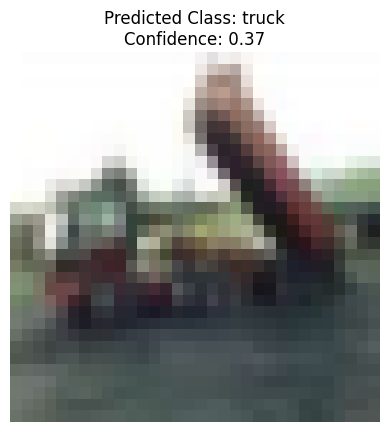

In [19]:

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])


dataset = datasets.CIFAR10(root='./cifar', train=True, download=True)


image, label = dataset[2]
classes = dataset.classes
image_np = np.array(image)


image = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)


input_image = transform(image_np)
input_image = input_image.unsqueeze(0)
input_image = input_image.to(device)

with torch.no_grad():

    outputs = loaded_net(input_image)
    _, predicted = torch.max(outputs, 1)

predicted_class = classes[predicted.item()]

confidence = torch.softmax(outputs, dim=1)[0][predicted.item()].item()


plt.imshow(image_np)
plt.title(f'Predicted Class: {predicted_class}\nConfidence: {confidence:.2f}')
plt.axis('off')
plt.show()


Files already downloaded and verified


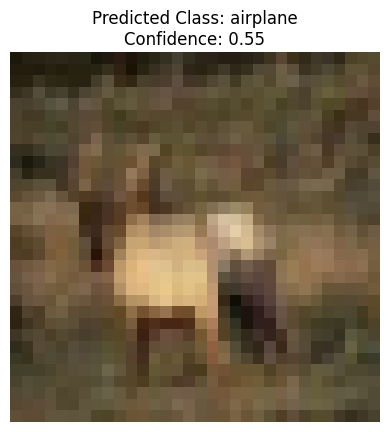

In [22]:

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])


dataset = datasets.CIFAR10(root='./cifar', train=True, download=True)


image, label = dataset[3]
classes = dataset.classes
image_np = np.array(image)


image = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)


input_image = transform(image_np)
input_image = input_image.unsqueeze(0)
input_image = input_image.to(device)

with torch.no_grad():

    outputs = loaded_net(input_image)
    _, predicted = torch.max(outputs, 1)

predicted_class = classes[predicted.item()]

confidence = torch.softmax(outputs, dim=1)[0][predicted.item()].item()


plt.imshow(image_np)
plt.title(f'Predicted Class: {predicted_class}\nConfidence: {confidence:.2f}')
plt.axis('off')
plt.show()


Files already downloaded and verified


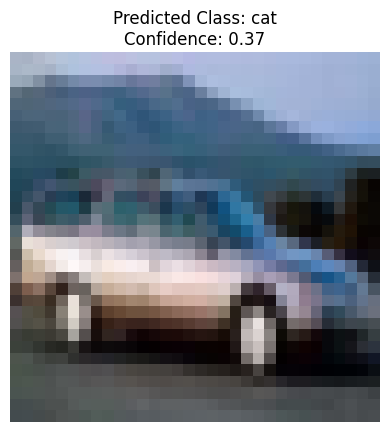

In [28]:

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])


dataset = datasets.CIFAR10(root='./cifar', train=True, download=True)


image, label = dataset[4]
classes = dataset.classes
image_np = np.array(image)


image = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)


input_image = transform(image_np)
input_image = input_image.unsqueeze(0)
input_image = input_image.to(device)

with torch.no_grad():

    outputs = loaded_net(input_image)
    _, predicted = torch.max(outputs, 1)

predicted_class = classes[predicted.item()]

confidence = torch.softmax(outputs, dim=1)[0][predicted.item()].item()


plt.imshow(image_np)
plt.title(f'Predicted Class: {predicted_class}\nConfidence: {confidence:.2f}')
plt.axis('off')
plt.show()
